In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline


from sklearn.tree import DecisionTreeClassifier


from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from category_encoders import WOEEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from category_encoders import OneHotEncoder

from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.plotting import plot_pca_correlation_graph


from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline, Pipeline

import joypy

import warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


**Read the Data**

In [2]:
df = pd.read_csv('churn.csv')
df_orig = pd.read_csv('churn.csv')
target = 'churn'
y = df[target]
labels = df.columns

**Look at the Data**

In [ ]:
df.head()

In [ ]:
df.info()

In [3]:
df = df.drop(['phone number'], axis = 1)
df = df.drop(['area code'], axis = 1)
df = df.drop(['state'], axis = 1)

In [ ]:
df.head()

In [4]:
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})
df['churn'] = df['churn'].map({True: 1, False: 0})

In [ ]:
df.head()

**Create Train Test split**

In [5]:
X = df.drop([target],axis = 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

**Log Reg**

In [7]:
scaler = MinMaxScaler()
lr = LogisticRegression()
pipe = make_pipeline(scaler, lr)

pipe.fit(X_train, y_train)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

In [9]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8168251868933503 +/- 0.023984851936874777


In [8]:
def stringify(data):
    df = pd.DataFrame(data)
    for c in df.columns.tolist():
        df[c] = df[c].astype(str)
    return df

binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
objectify = FunctionTransformer(func=stringify, 
                                validate=False)
clf = LogisticRegression(class_weight='balanced')
encoder = WOEEncoder()
scorecard = make_pipeline(binner, objectify, encoder, lr)


scores = cross_val_score(scorecard, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.7328425122083561 +/- 0.0631623630836474


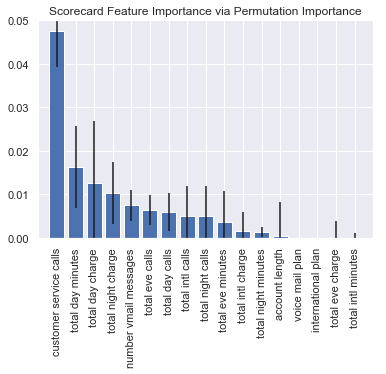

In [11]:
X = Pipeline(scorecard.steps[:-1]).fit_transform(X, y).values
used_cols = [c for c in df.columns.tolist() if c not in [target]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

clf.fit(X_train, y_train)
imp_vals, imp_all = feature_importance_permutation(
    predict_method=clf.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=10,
    seed=1)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Scorecard Feature Importance via Permutation Importance")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
# plt.xticks(range(X.shape[1]), indices)
plt.xticks(range(X.shape[1]), np.array(used_cols)[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.05])
plt.show()

In [ ]:
important_feat = ['customer service calls', 'total day minutes','total intl calls']

**Random Forest**

In [9]:
from sklearn.base import TransformerMixin

class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))

In [10]:
#entropy criterion
used_cols = [c for c in df.columns.tolist() if c not in [target]]
X, y = df[used_cols].values, df[target].values

N = 5

rf = RandomForestClassifier(max_depth = N, n_estimators=100, n_jobs=-1, random_state=42,criterion = 'entropy', max_leaf_nodes = 2**N-1)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X, y)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9149538418641103 +/- 0.02672463524260183


In [14]:
#gini criterion

rf = RandomForestClassifier(max_depth = N, n_estimators=100, n_jobs=-1, random_state=42,criterion = 'gini', max_leaf_nodes = 2**N-1)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X, y)

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9117358096702237 +/- 0.026628725441639613


In [15]:
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9114688460842828 +/- 0.02350278363865098


Feature ranking:
1. feature 1 (0.184767)
2. feature 16 (0.165225)
3. feature 4 (0.125292)
4. feature 6 (0.121801)
5. feature 14 (0.058951)
6. feature 7 (0.051460)
7. feature 9 (0.047494)
8. feature 2 (0.046428)
9. feature 3 (0.038171)
10. feature 10 (0.027895)
11. feature 12 (0.025990)
12. feature 13 (0.023818)
13. feature 15 (0.022335)
14. feature 5 (0.016438)
15. feature 0 (0.015451)
16. feature 11 (0.014514)
17. feature 8 (0.013971)


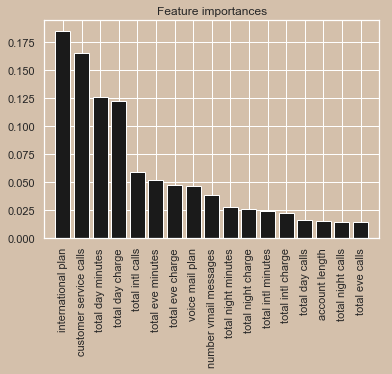

In [88]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
sns.set(rc={'axes.facecolor':'#d4c0ab','figure.facecolor':'#d4c0ab'})

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="k", yerr=std[indices],align="center")
plt.xticks(range(X.shape[1]), np.array(used_cols)[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
rf_imp_feat = ['total day charge','total day minutes','total eve charge']

**Dealing with Imbalances**

In [11]:
#smote to affect imbalances. Makes more target data for the target since it was so low

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

N = 5

rf = RandomForestClassifier(max_depth = N, n_estimators=100, n_jobs=-1, 
                            random_state=42,criterion = 'entropy', 
                            max_leaf_nodes = 2**N-1)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X_resampled, y_resampled)



Pipeline(memory=None,
         steps=[('forestencoder',
                 <__main__.ForestEncoder object at 0x13ac657f0>),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [17]:
scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9607106802092952 +/- 0.0183133429135206


**Hyper Parameter Tuning**

In [18]:
#create train test split for resampled data

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)

In [21]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2', 0.2],
          "max_depth": [4, 6, 10],
          "min_samples_split": [2, 5, 10],
          "min_samples_leaf": [1, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy', max_depth=10,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [22]:
grid_search.best_score_

0.9859706832871653

In [23]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [19]:
rf = RandomForestClassifier(criterion='entropy',
 max_depth=10,
 max_features='sqrt',
 min_samples_leaf=1,
 min_samples_split=5,
 n_estimators=20)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X_resampled, y_resampled)

scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9834955370883348 +/- 0.01302522862543784


In [20]:
rf = RandomForestClassifier(criterion='entropy',
 max_depth=10,
 max_features='sqrt',
 min_samples_leaf=5,
 min_samples_split=2,
 n_estimators=100)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X_resampled, y_resampled)

scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9851074176669744 +/- 0.012909561600842914


In [24]:
rf = RandomForestClassifier(criterion='entropy',
 max_depth=10,
 max_features='log2',
 min_samples_leaf=1,
 min_samples_split=2,
 n_estimators=100)
encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)
pipe.fit(X_resampled, y_resampled)

scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9870594028931979 +/- 0.011035529714846379


In [30]:
df.columns.tolist()

['account length',
 'international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'churn']

In [31]:
plot_cols = [c for c in df.columns.tolist() if c not in ['churn']]
#f2efe5
#d4c0ab

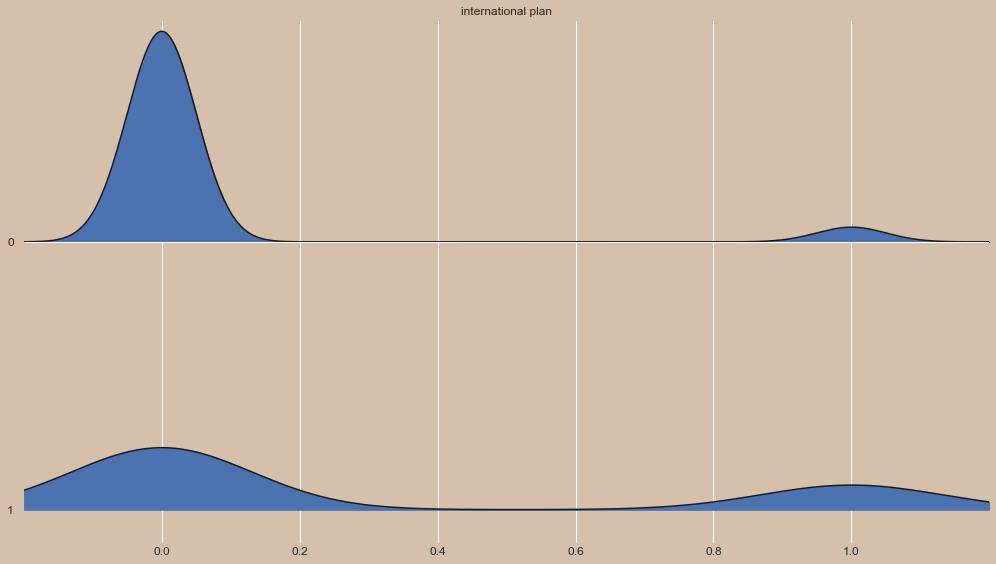

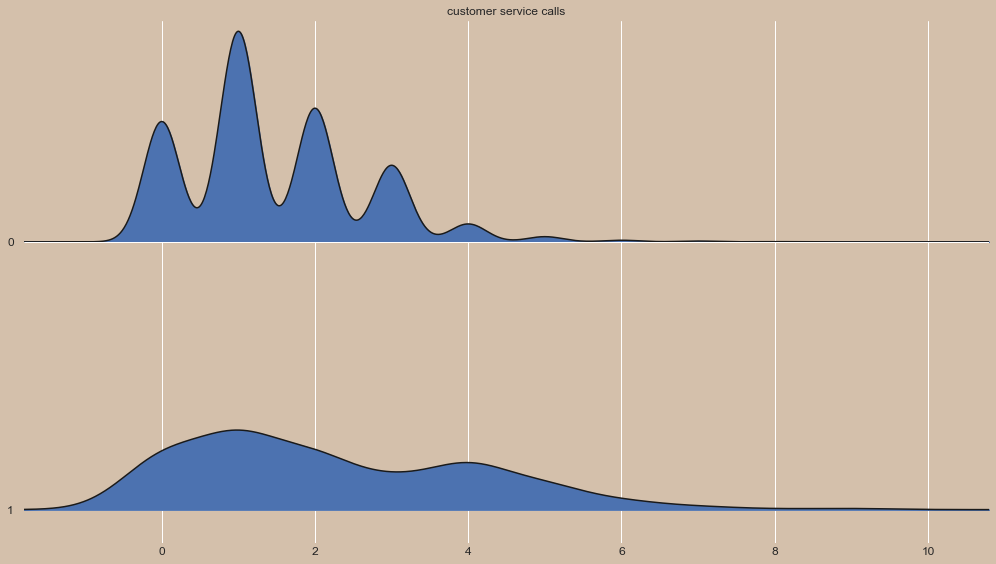

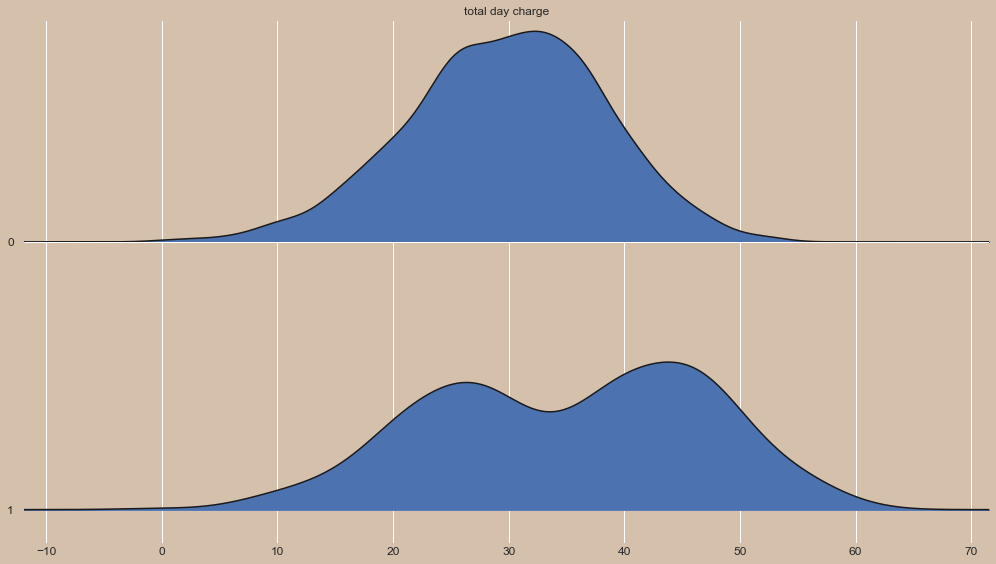

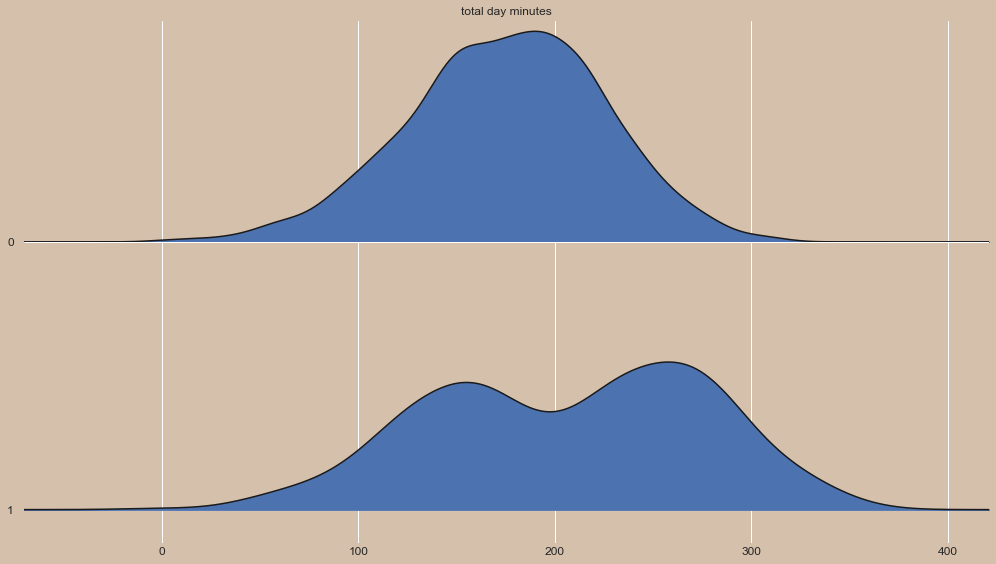

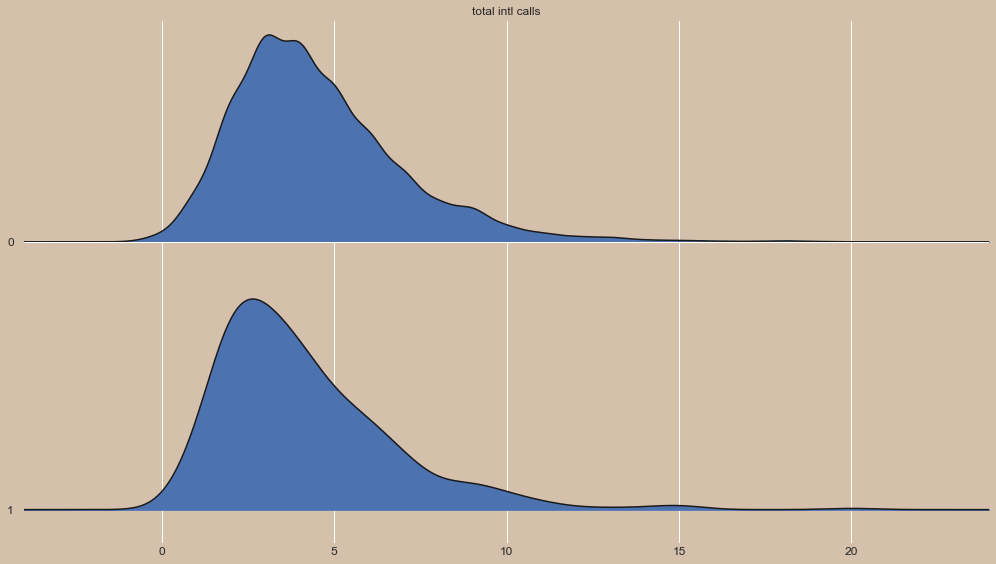

In [92]:
SIZE = (14,8)

imp_cols = ['international plan','customer service calls','total day charge','total day minutes','total intl calls',]
for cols in imp_cols:
        fig, axes = joypy.joyplot(df, 
                              by=target,
                              column=cols,
                              background = '#d4c0ab',
                              ylim='max',
                              overlap=2,
                              grid=True,
                              legend=False,
                              title=cols,
                              figsize = SIZE)
        plt.tight_layout()
        plt.show()

In [99]:

states = df_orig['state'].unique()
states

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [165]:
plot_df = pd.read_csv('forplotting.csv')
labels = plot_df.columns
true = []
false = []

In [161]:
plot_df.head()

,state,churn,totals
0,AK,False,49
1,AK,True,3
2,AL,False,72
3,AL,True,8
4,AR,False,44


In [164]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(plot_df)

    state  churn  totals
0      AK  False      49
1      AK   True       3
2      AL  False      72
3      AL   True       8
4      AR  False      44
5      AR   True      11
6      AZ  False      60
7      AZ   True       4
8      CA  False      25
9      CA   True       9
10     CO  False      57
11     CO   True       9
12     CT  False      62
13     CT   True      12
14     DC  False      49
15     DC   True       5
16     DE  False      52
17     DE   True       9
18     FL  False      55
19     FL   True       8
20     GA  False      46
21     GA   True       8
22     HI  False      50
23     HI   True       3
24     IA  False      41
25     IA   True       3
26     ID  False      64
27     ID   True       9
28     IL  False      53
29     IL   True       5
30     IN  False      62
31     IN   True       9
32     KS  False      57
33     KS   True      13
34     KY  False      51
35     KY   True       8
36     LA  False      47
37     LA   True       4
38     MA  False      54


In [191]:
# plot_df['percent'] = plot_df['totals']/
df_orig.groupby('state')['churn'].value_counts(normalize=True).sort_values()

state  churn
HI     True     0.056604
AK     True     0.057692
AZ     True     0.062500
VA     True     0.064935
IA     True     0.068182
                  ...   
       False    0.931818
VA     False    0.935065
AZ     False    0.937500
AK     False    0.942308
HI     False    0.943396
Name: churn, Length: 102, dtype: float64

In [193]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_orig.groupby('state')['churn'].value_counts(normalize=True).sort_values())

state  churn
HI     True     0.056604
AK     True     0.057692
AZ     True     0.062500
VA     True     0.064935
IA     True     0.068182
LA     True     0.078431
NE     True     0.081967
IL     True     0.086207
WI     True     0.089744
RI     True     0.092308
DC     True     0.092593
WV     True     0.094340
TN     True     0.094340
NM     True     0.096774
ND     True     0.096774
AL     True     0.100000
VT     True     0.109589
MO     True     0.111111
WY     True     0.116883
ID     True     0.123288
IN     True     0.126761
FL     True     0.126984
OH     True     0.128205
SD     True     0.133333
KY     True     0.135593
CO     True     0.136364
UT     True     0.138889
OR     True     0.141026
DE     True     0.147541
OK     True     0.147541
GA     True     0.148148
NH     True     0.160714
NC     True     0.161765
CT     True     0.162162
MA     True     0.169231
PA     True     0.177778
MN     True     0.178571
NY     True     0.180723
KS     True     0.185714
AR     True 